# Imports

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import calplot #Used to heatmap timeseries data

from datetime import datetime

from sklearn.metrics import confusion_matrix

Data derived from https://www.kaggle.com/competitions/store-sales-time-series-forecasting

In [2]:
store_sales = pd.DataFrame(pd.read_csv(r"C:\Projects\Visual\Python_projects\store-sales-time-series-forecasting\store_sales.csv"))


# Timeseries Analysis

Firstly, lets have a look at the data...

In [3]:
store_sales

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0
1,1,2013-01-01,1,BABY CARE,0.000,0
2,2,2013-01-01,1,BEAUTY,0.000,0
3,3,2013-01-01,1,BEVERAGES,0.000,0
4,4,2013-01-01,1,BOOKS,0.000,0
...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8


In [4]:
store_sales.drop('id', axis=1, inplace=True) #This is just the index so I have opted to drop it straight away.

The data is that of many product families sold in stores in the country of Ecuador between 2013-2017.

The data is quite simplistic.
The attributes include
* Date of the sales
* The store number is the id of the store
* The family identifies the type of product
* The number of sales
* The number of products of the family of products are on sale

In this project, I will be performing a simple timeseries analysis of this dataset. 


A magnitude 7.8 earthquake struck Ecuador on April 16, 2016

### Initial exploration

In [5]:
store_sales.dtypes

date            object
store_nbr        int64
family          object
sales          float64
onpromotion      int64
dtype: object

In [6]:
store_sales.isna().sum()

date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

<AxesSubplot:>

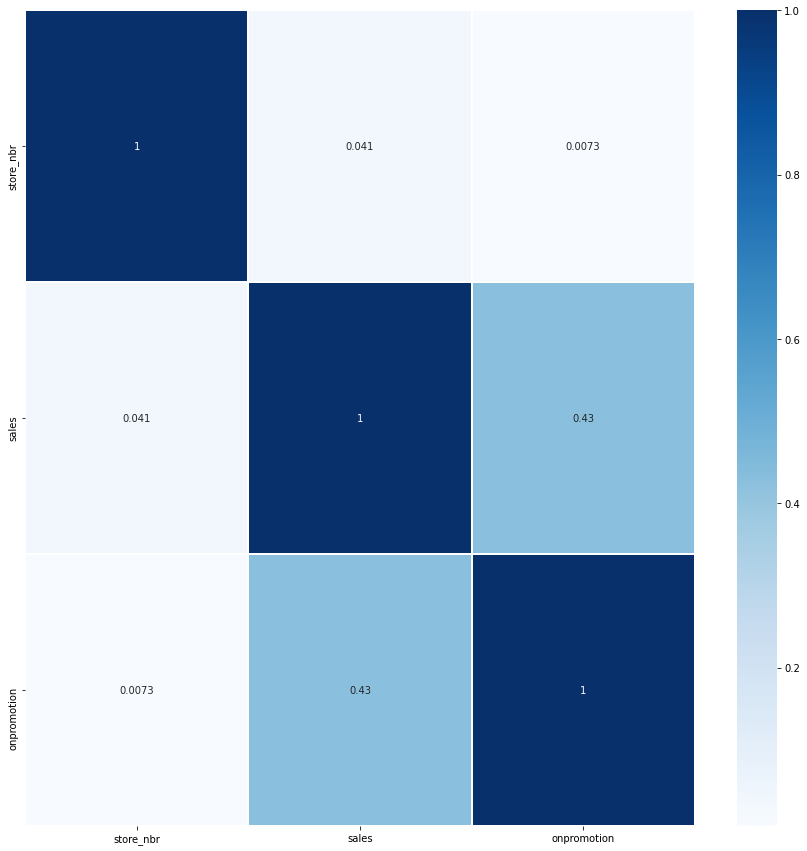

In [7]:
plt.figure(figsize=(15,15))

sns.heatmap(
    store_sales.corr(),
    annot = True,
    cmap = 'Blues',
    linewidths = .2
)


Having a quick look at the correlation between the attributes, there are some clear observations. 
As we might expect from such an attribute, a product family on promotion has a strong positive correlation to the sales of that family. 
Simply going off this heatmap, there are no other interesting clear correlators.

### Date vs sales

Ideally, from timeseries exploration, we want to find interesting patterns and an explanation for these patterns. The patterns we want to analyse are...
* Trends
* Seasonality
* Cyclicity


<AxesSubplot:xlabel='year', ylabel='sales'>

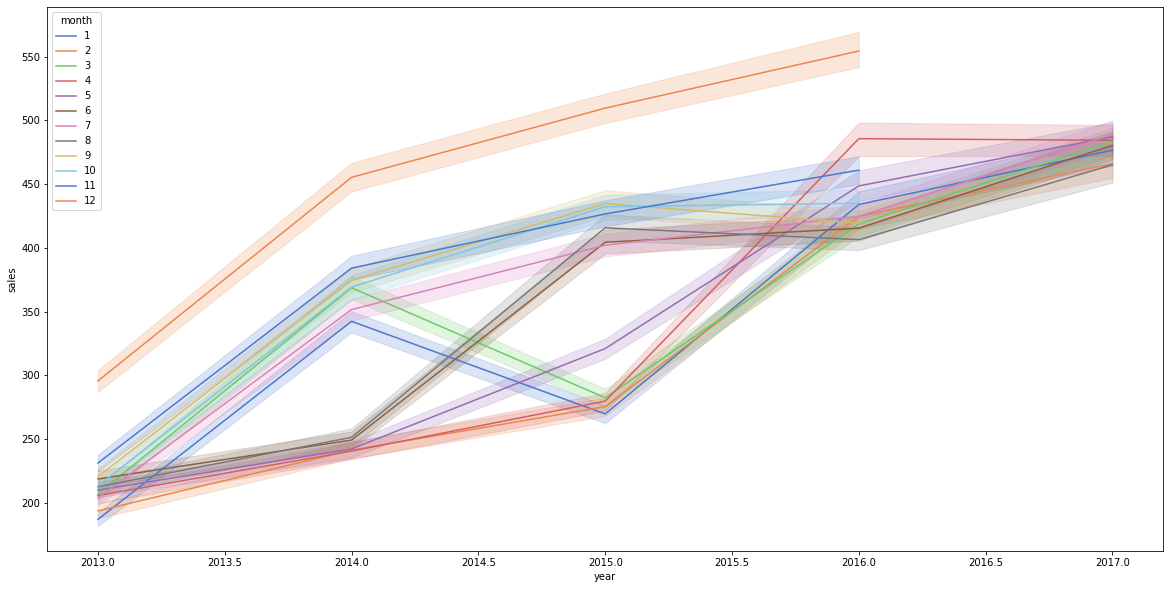

In [8]:
store_sales['date'] = pd.to_datetime(store_sales.date, format='%Y/%m/%d')

store_sales['day'] = pd.DatetimeIndex(store_sales.date).day
store_sales['month'] = pd.DatetimeIndex(store_sales.date).month
store_sales['year'] = pd.DatetimeIndex(store_sales.date).year

fig, ax = plt.subplots(figsize=(20,10))

sns.lineplot(
    data = store_sales,
    x = 'year', 
    y = 'sales',
    hue = 'month',
    palette='muted'
)

In [9]:
pre = store_sales[store_sales.date < pd.to_datetime('2016-1-1', format='%Y/%m/%d')]
post = store_sales[store_sales.date >= pd.to_datetime('2016-1-1', format='%Y/%m/%d')]

print(f"Pre-2016, the average sale count is {pre.sales.mean()}")
print(f"In/post-2016, the average sale count is {post.sales.mean()}")
print(f"An increase of {round( (pre.sales.mean() / post.sales.mean())*100, 2)}%")

Pre-2016, the average sale count is 303.5921695978411
In/post-2016, the average sale count is 457.72248700136413
An increase of 66.33%


This lineplot reveals a few things for us.
* Cyclicity is not apparent in this data. There appear to be no rises or falls over the 4 years.
* There is a clear linear and increasing trend. 
* Seasonally, December and November are associated with an increase of sales wheras, before 2016, the ealier months dragged their feet in sales. Post-2016, sales increased ~66%. This was likely influenced by the 7.8 earthquake on April 16, 2016.

In [10]:
mean = store_sales[['date', 'sales']]
mean['date'] = pd.to_datetime(mean.date, format='%Y/%m/%d')
mean.set_index('date', inplace=True)

C:\Users\CL-11\AppData\Local\Temp/ipykernel_25168/2611763367.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mean['date'] = pd.to_datetime(mean.date, format='%Y/%m/%d')


findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


(<Figure size 900x612 with 6 Axes>,
 array([<AxesSubplot:ylabel='2013'>, <AxesSubplot:ylabel='2014'>,
        <AxesSubplot:ylabel='2015'>, <AxesSubplot:ylabel='2016'>,
        <AxesSubplot:ylabel='2017'>], dtype=object))

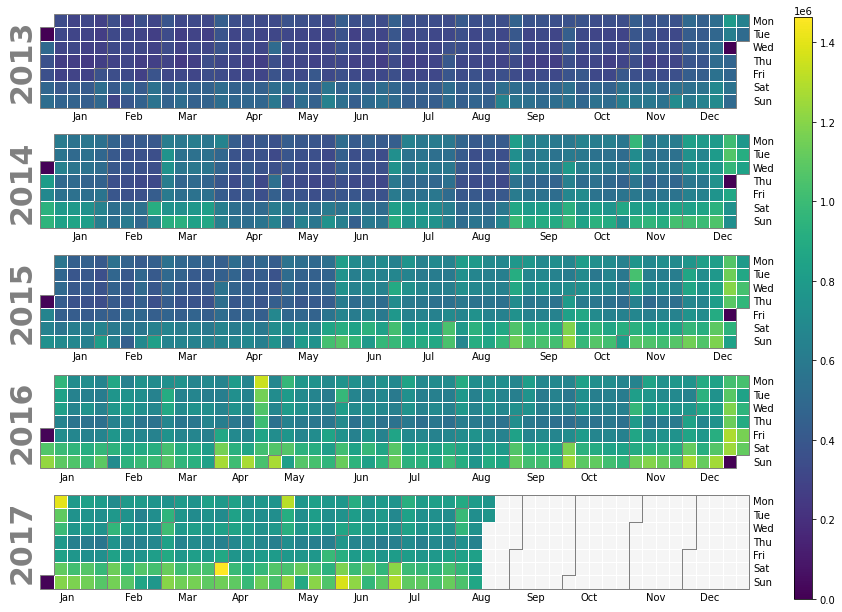

In [11]:
calplot.calplot(mean['sales'])

What is immedietly apparent is that over the years sales have increased across the board. We addressed this earlier. 

#### Months
* There looks to be a seasonal pattern, like a wave. 
* The sales increase substantially over the years across the entire current year. 

#### Days
* Looking closely, we can also see that weekends are very successful over the entire 4-1/2 years. 
* In fact, it looks as the later the week goes, so do the sales increase. This is worth investigating.

## Month

In [12]:
months = {
    1 : 'Jan', 2 : 'Feb', 3 : 'Mar', 4 : 'Apr',
    5 : 'May', 6 : 'Jun', 7 : 'Jul', 8 : 'Aug',
    9 : 'Sep', 10 : 'Oct', 11 : 'Nov', 12 : 'Dec'}

In [13]:
m = store_sales.groupby("month").sales.mean().reset_index()
m.month.replace(months, inplace=True)
m

,month,sales
0,Jan,341.921554
1,Feb,320.928869
2,Mar,352.009294
3,Apr,339.199841
4,May,341.765820
5,Jun,353.597842
6,Jul,374.219111
7,Aug,336.992535
8,Sep,362.297418
9,Oct,362.407132


<AxesSubplot:xlabel='month', ylabel='sales'>

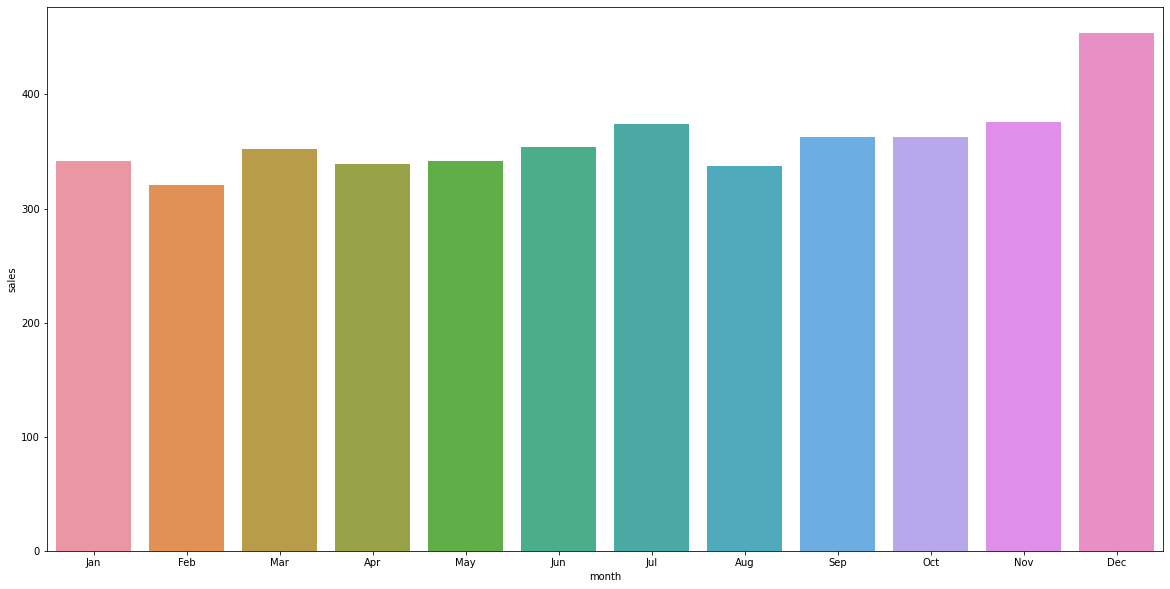

In [14]:
fig, ax = plt.subplots(figsize=(20,10))
sns.barplot(
    data = m,
    x = 'month',
    y = 'sales'
)

In [15]:
m

,month,sales
0,Jan,341.921554
1,Feb,320.928869
2,Mar,352.009294
3,Apr,339.199841
4,May,341.765820
5,Jun,353.597842
6,Jul,374.219111
7,Aug,336.992535
8,Sep,362.297418
9,Oct,362.407132


A distinct wave is quite apparent when looking at month v sales. 

This may imply a seasonal wave pattern.

## Days

<AxesSubplot:>

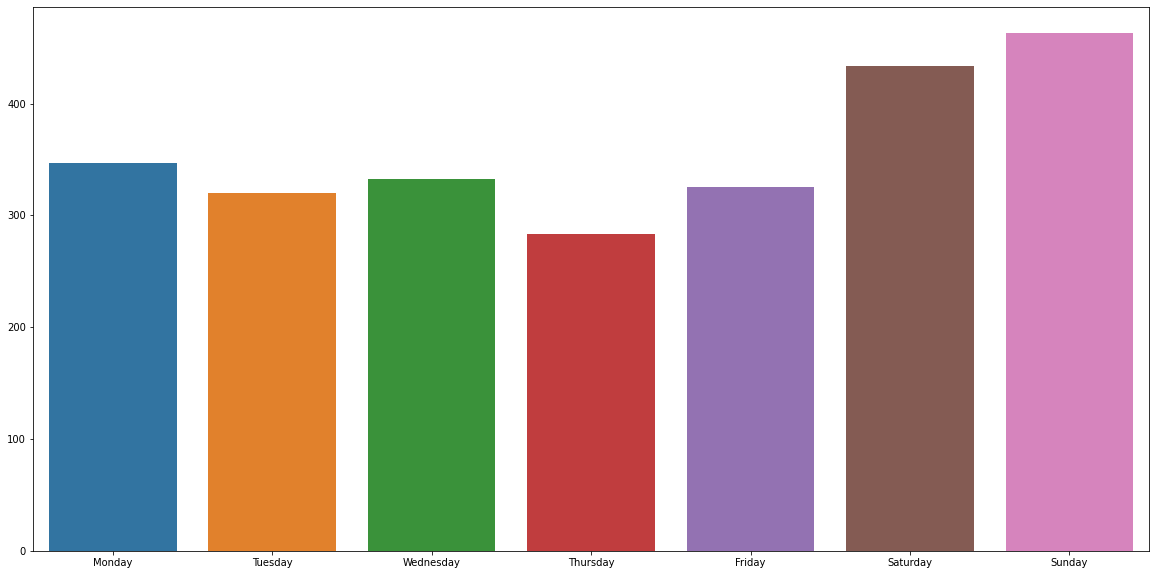

In [16]:
days = {
    0 : 'Monday',
    1 : 'Tuesday',
    2 : 'Wednesday',
    3 : 'Thursday',
    4 : 'Friday',
    5 : 'Saturday',
    6 : 'Sunday'
}
store_sales['day'] = store_sales.date.dt.weekday
store_sales.day.replace(days, inplace=True)

d = store_sales.groupby("day").sales.mean().reset_index()

fig, ax = plt.subplots(figsize=(20,10))
sns.barplot(
    data = d,
    x = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
    y = [d.iloc[1][1], d.iloc[5][1], d.iloc[6][1], d.iloc[4][1], d.iloc[0][1], d.iloc[2][1], d.iloc[3][1]]
)

In [17]:
d

,day,sales
0,Friday,325.238138
1,Monday,346.544732
2,Saturday,433.336472
3,Sunday,463.085366
4,Thursday,283.540517
5,Tuesday,319.823843
6,Wednesday,332.909401


Our suspicions were warrented. It is obvious that Satuday and Sunday have the best sales, with increased sales bleeding into Monday just a little. 

### Conclusion

From the timeseries analysis we can conclude a few things...

* Novemberer-December were the most successful months for selling products, however, after the earthquake disaster, people began buying all year round, reducing the number of sales in November and December. 
* The causality for the increase in sales was the need for supplies after the earthquake.
* In general, stores perform better in the late-week and weekends. 
* The best sales are on Sundays.
* December had the best sales. 